7/7 [==============================] - 0s 2ms/step


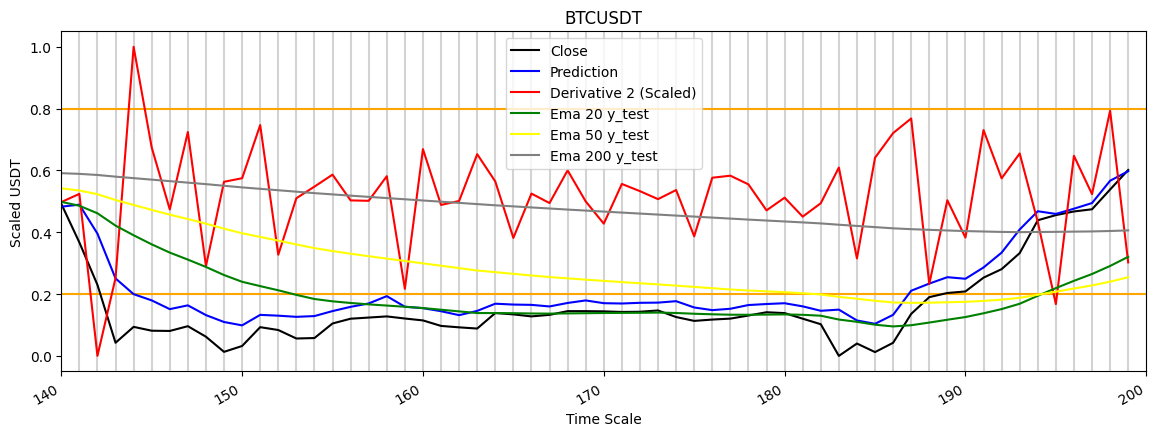

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import constantes as cons
import keras 
import datetime as dt

symbol =  str.upper('btc'+'USDT')
client = cons.client

umbralbajo=0.2
umbralalto=0.8

# esta funcion solo la uso en el notebook ya que en el programa se hace con pandas_ta
def ema (signal,N=10):
    k = 2 / (N + 1)  # Factor de suavizado
    ema = np.zeros_like(signal)  # Array para almacenar los valores de la EMA
    ema[0] = signal[0]  # El primer valor de la EMA es igual al primer valor de deriv_y_pred_scaled2
    for i in range(1, len(signal)):
        ema[i] = (signal[i] * k) + (ema[i-1] * (1 - k))
    return ema
#######################################################################################

timeframe='30m'
historical_data = client.get_historical_klines(symbol, timeframe)
data = pd.DataFrame(historical_data)
data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
data['Open Time'] = pd.to_datetime(data['Open Time']/1000, unit='s')
data['Close Time'] = pd.to_datetime(data['Close Time']/1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, axis=1)
data['timestamp']=data['Open Time']
data.set_index('timestamp', inplace=True)

data.dropna(inplace=True)
data.drop(['Open Time','Close Time','Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume','Number of Trades',
          'Ignore'], axis=1, inplace=True)
stock_data = data
pd.set_option('display.max_columns', None)

############################################################################################

X_feat = stock_data.iloc[:,0:3]

X_ft = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns,data=X_ft,index=X_feat.index)

def ltsm_split (data,n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps+1):
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps-1, -1])
    return np.array(X),np.array(y)

n_steps=1
X1, y1 = ltsm_split(X_ft.values, n_steps=n_steps)

train_split =0.8
split_idx = int(np.ceil(len(X1)*train_split))

X_train , X_test = X1[:split_idx], X1[split_idx:]
y_train , y_test = y1[:split_idx], y1[split_idx:]

lstm=Sequential()
lstm.add(LSTM(32,input_shape=(X_train.shape[1],X_train.shape[2]),activation='relu',return_sequences=True))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error',optimizer='adam')

#lstm.fit(X_train,y_train,epochs=20,batch_size=4,verbose=2,shuffle=False)
lstm = keras.models.load_model('modelos/lstm'+symbol+'.h5')

# señales para la grafica
y_pred = lstm.predict(X_test)
# Calcular las derivadas
deriv_y_pred = np.diff(y_pred, axis=0)
deriv_y_pred2 = np.diff(deriv_y_pred, axis=0)
# Ajustar la forma de deriv_y_pred
deriv_y_pred = deriv_y_pred.reshape(-1, 1)
deriv_y_pred2 = deriv_y_pred2.reshape(-1, 1)
# Escalar las derivadas
scaler1 = MinMaxScaler(feature_range=(0, 1))
deriv_y_pred_scaled = scaler1.fit_transform(deriv_y_pred)
scaler2 = MinMaxScaler(feature_range=(0, 1))
deriv_y_pred_scaled2 = scaler2.fit_transform(deriv_y_pred2)
deriv_y_pred_scaled = np.insert(deriv_y_pred_scaled, 0, deriv_y_pred_scaled[0], axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, deriv_y_pred_scaled2[0], axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, deriv_y_pred_scaled2[0], axis=0)#para mover 1 posicion hacia adelante

ema_deriv=ema(deriv_y_pred_scaled)
ema_deriv = MinMaxScaler(feature_range=(0, 1)).fit_transform(ema_deriv)
ema_deriv2=ema(deriv_y_pred_scaled2,50)
ema_deriv2 = MinMaxScaler(feature_range=(0, 1)).fit_transform(ema_deriv2)
ema_y_test_20=ema(y_test,20)
ema_y_test_50=ema(y_test,50)
ema_y_test_200=ema(y_test,200)

#grafica

plt.figure(figsize=(14, 5))
time_index = range(n_steps-1, n_steps-1+len(y_pred))
# Agregar líneas verticales
for i in time_index:
    plt.axvline(x=i, color='lightgray')
plt.xlim(140,len(y_test))
plt.axhline(y = umbralalto, color = 'orange', linestyle = '-')
#plt.axhline(y = 0.5, color = 'GREY', linestyle = '-')
plt.axhline(y = umbralbajo, color = 'orange', linestyle = '-')
plt.plot(y_test, label='Close',color = 'black')

plt.plot( y_pred[:, -1, 0], label='Prediction',color = 'blue')
#plt.plot(deriv_y_pred_scaled, label='Derivative 1 (Scaled)',color = 'blue')
plt.plot( deriv_y_pred_scaled2, label='Derivative 2 (Scaled)', color='red')
#plt.plot( ema_deriv, label='Ema Derivative 1 (Scaled)', color='green')
#plt.plot( ema_deriv2, label='Ema Derivative 2 (Scaled)', color='orange')

plt.plot( ema_y_test_20, label='Ema 20 y_test', color='green')
plt.plot( ema_y_test_50, label='Ema 50 y_test', color='yellow')
plt.plot( ema_y_test_200, label='Ema 200 y_test', color='grey')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USDT')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title(symbol)
#plt.grid()

plt.show()
